# Get Data and Preprocess

In [27]:
import pandas as pd
df = pd.read_csv('./Texas Last Statement - CSV.csv', encoding = 'ISO-8859-1')

In [28]:
print(df['LastStatement'][0])

This is my statement: My final words. First, I want to thank my family for believing in me and being there with me till the end. I love you all very much! And I know that you love me too! Life does go on. Next, I would like to also thank my attorney?s Maurie Levin, Alicia Amezcua Rodriguez and Sandra Babcock for all their hard work they have done to help me out. I am so thankful.ÿ I would also like to thank the Mexican Consul for all their help too, and every government official that was trying to help me out too. Thank you Maricela Luna and Julia Thimm for being such good friends!ÿÿNow!ÿ I will not and cannot apologize for someone else?s crime, but, I will be back for justice!ÿ You can count on that! Thank you.


In [29]:
inmates = {}
inmatenum = 0
for row in df.iterrows():
    inmates[inmatenum] = {}
    inmates[inmatenum]['LastName'] = row[1]['LastName']
    inmates[inmatenum]['Age'] = row[1]['Age']
    inmates[inmatenum]['Race'] = row[1]['Race']
    inmates[inmatenum]['AgeWhenReceived'] = row[1]['AgeWhenReceived']
    try:
        inmates[inmatenum]['NumVictims'] = int(row[1]['MaleVictim']) + int(row[1]['FemaleVictim'])
    except:
        inmates[inmatenum]['NumVictims'] = -1
    inmates[inmatenum]['LastStatement'] = row[1]['LastStatement']
    inmatenum = inmatenum + 1

In [30]:
for inm in list(inmates):
    if inmates[inm]['LastStatement'] == 'None':
        del inmates[inm]

In [31]:
import re
import nltk
from nltk.corpus import stopwords

stopset = set(stopwords.words('english'))

letters = re.compile('[^a-zA-Z]')
for inm in inmates:
    words = inmates[inm]['LastStatement']
#     print(words)
    words = letters.sub(' ', words)
    words = words.split()
    ls = []
    for w in words:
        if w not in stopset:
            ls.append(w)
    inmates[inm]['LastStatement'] = " ".join(ls)
#     print(inmates[inm]['LastStatement'])

In [32]:
len(inmates)

431

# Embeddings

In [33]:
for inm in inmates:
    inmates[inm]['SpaCy'] = 0
    inmates[inm]['FastText'] = 0
    inmates[inm]['USE'] = 0
    inmates[inm]['ElMo'] = 0

In [34]:
import spacy 
nlp = spacy.load('en_core_web_lg')

In [35]:
import fastText
ftmodel = fastText.load_model('../firstWeek/crawl-300d-2M-subword.bin')

In [ ]:
from nltk.tokenize import word_tokenize
def get_fastText_uniform(statements):
    embeddings = []
    for statement in statements:
        s = 0
        c = 0
        for w in word_tokenize(statement):
            c = c + 1
            s = s + ftmodel.get_word_vector(w)
        embeddings.append(s/c)
    return embeddings
        

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer

def tfidf_encoding(ls):
    count_vect = CountVectorizer()
    X_train_counts = count_vect.fit_transform(ls)
    tf_transformer = TfidfTransformer(use_idf=False).fit(X_train_counts)
    X_train_tf = tf_transformer.transform(X_train_counts)
    return X_train_tf

In [ ]:
import numpy as np
from sklearn.cluster import KMeans

def get_cluster_and_tsne(embeddings, km):
    k = km
    np.array(embeddings).shape
    kmeans = KMeans(n_clusters=k, init='k-means++', random_state=2018).fit(embeddings)
    clusters = kmeans.predict(embeddings)
    
    arr = np.array(embedding)
    tsne = TSNE(n_components=2, random_state=512)
    reduced = tsne.fit_transform(arr)       
    t = np.array(reduced).transpose()
    
    return clusters, t

In [10]:
spacy_embedding = []
for inm in inmates:
    s = 0
    c = 0
    for w in inmates[inm]['LastStatement'].split():
        c = c + 1
        s = s + ftmodel.get_word_vector(w)
    inmates[inm]['SpaCy'] = s/c

In [11]:
import tensorflow as tf
import tensorflow_hub as hub

useurl = "https://tfhub.dev/google/universal-sentence-encoder/2"
usemodel = hub.Module(useurl)

INFO:tensorflow:Using /var/folders/g_/xk6_mjn17sl4btmd7cwv7fz5xbp8s_/T/tfhub_modules to cache modules.


In [12]:
inmno = []
ls = []
for inm in inmates:
    inmno.append(inm)
    ls.append(inmates[inm]['LastStatement'])

In [13]:
# Reduce logging output.
tf.logging.set_verbosity(tf.logging.ERROR)

with tf.Session() as session:
    session.run([tf.global_variables_initializer(), tf.tables_initializer()])
    useEmbed = session.run(usemodel(ls))

KeyboardInterrupt: 

In [ ]:
print(len(useEmbed))

In [ ]:
for i,j in zip(inmno,useEmbed):
    inmates[i]['USE'] = j

In [ ]:
elmourl = "https://tfhub.dev/google/elmo/2"
elmomodel = hub.Module(elmourl)

In [ ]:
# Reduce logging output.
tf.logging.set_verbosity(tf.logging.ERROR)

with tf.Session() as session:
    session.run([tf.global_variables_initializer(), tf.tables_initializer()])
    elmoEmbed = session.run(elmomodel(ls))

In [ ]:
inmno = []
ls = []
for i,j in zip(inmno,elmoEmbed):
    inmates[i]['ElMo'] = j

In [ ]:
for inm in inmates:
    print(inmates[inm]['ElMo'])
    break

# TSNE, PCA, Clustering

In [25]:
from sklearn.cluster import KMeans
from sklearn.manifold import TSNE
import numpy as np

embedding = []

for inm in inmates:
    embedding.append(inmates[inm]['SpaCy'])

arr = np.array(embedding)

# pca = PCA(n_components=2)
# reduced = pca.fit_transform(arr)

tsne = TSNE(n_components=2)
reduced = tsne.fit_transform(arr)

t = reduced.transpose()

c = 6

kmeans = KMeans(n_clusters=c, random_state=0).fit(embedding)
clusters = kmeans.predict(embedding)

# aggcl = AgglomerativeClustering(n_clusters=c).fit_predict(embedding)
# clusters = aggcl

# dbscan = DBSCAN(eps=0.8,min_samples=20).fit_predict(embedding)
# clusters = dbscan

# spec = SpectralClustering(n_clusters=c).fit_predict(embedding)
# clusters = spec

# Plot by Race

In [19]:
from matplotlib.lines import Line2D
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(20, 10))

markerDict = {0: "x", 1: "v", 2: "o", 3:"s", 4: "D" , 5: ">", 6: "<"}
colorDict = {0: "r", 1: "g", 2: "b", 3:"c", 4: "m" , 5: "y", 6: "k"}

raceDict = {'Black': 0, 'White': 1, 'Hispanic': 2, 'Other': 4}


markers = []
colors = []

    
for inm in inmates:
    markers.append(markerDict[raceDict[inmates[inm]['Race']]])
    colors.append(colorDict[raceDict[inmates[inm]['Race']]])


for x,y,c,m in zip(t[0],t[1],colors,markers):
    ax.scatter(x, y, c=c, marker=m)
    

types = []

for race in raceDict:
    types.append(Line2D([0], [0], marker=markerDict[raceDict[race]], color=colorDict[raceDict[race]], label=race, markerfacecolor=colorDict[raceDict[race]], markersize=10))

ax.legend(handles=types, loc='upper left', fontsize='x-large')

plt.show()

<Figure size 2000x1000 with 1 Axes>

# Plot by Age

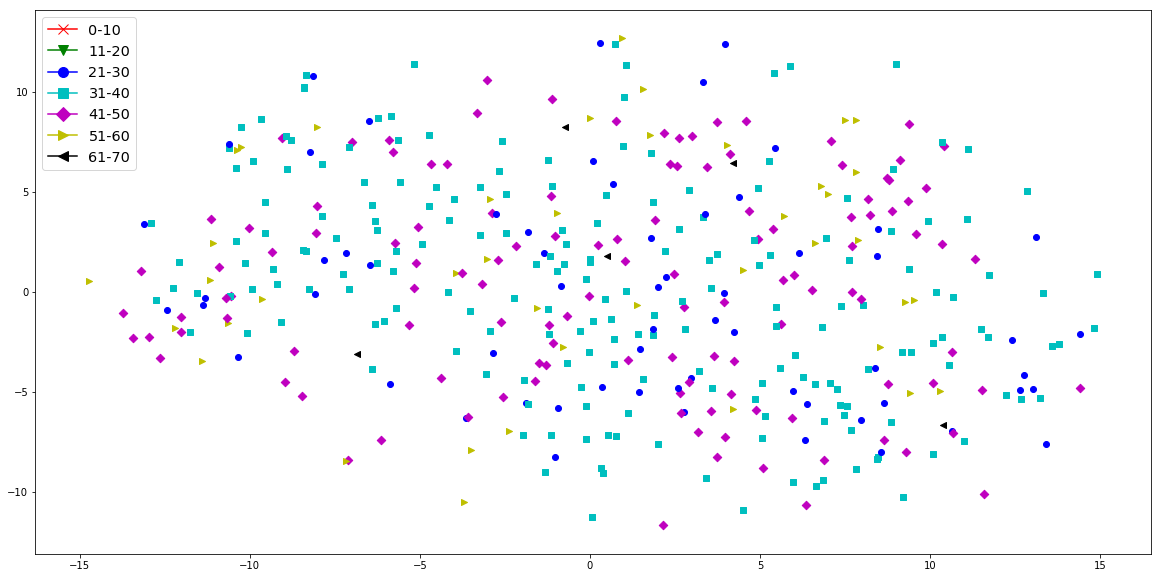

In [26]:
from matplotlib.lines import Line2D

fig, ax = plt.subplots(figsize=(20, 10))

def get_age_range(age):
    if age <= 10:
        return '0-10'
    elif age <= 20:
        return '11-20'
    elif age <= 30:
        return '21-30'
    elif age <= 40:
        return '31-40'
    elif age <= 50:
        return '41-50'
    elif age <= 60:
        return '51-60'
    else:
        return '61-70'

markerDict = {0: "x", 1: "v", 2: "o", 3:"s", 4: "D" , 5: ">", 6: "<"}
colorDict = {0: "r", 1: "g", 2: "b", 3:"c", 4: "m" , 5: "y", 6: "k"}

ageDict = {'0-10': 0, '11-20':1,'21-30':2, '31-40':3,'41-50':4,'51-60':5,'61-70':6}

markers = []
colors = []

    
for inm in inmates:
    markers.append(markerDict[ageDict[get_age_range(inmates[inm]['Age'])]])
    colors.append(colorDict[ageDict[get_age_range(inmates[inm]['Age'])]])


for x,y,c,m in zip(t[0],t[1],colors,markers):
    ax.scatter(x, y, c=c, marker=m)
    

types = []

for age in ageDict:
    types.append(Line2D([0], [0], marker=markerDict[ageDict[age]], color=colorDict[ageDict[age]], label=age, markerfacecolor=colorDict[ageDict[age]], markersize=10))

ax.legend(handles=types, loc='upper left', fontsize='x-large')


plt.show()

# Plot by Victims

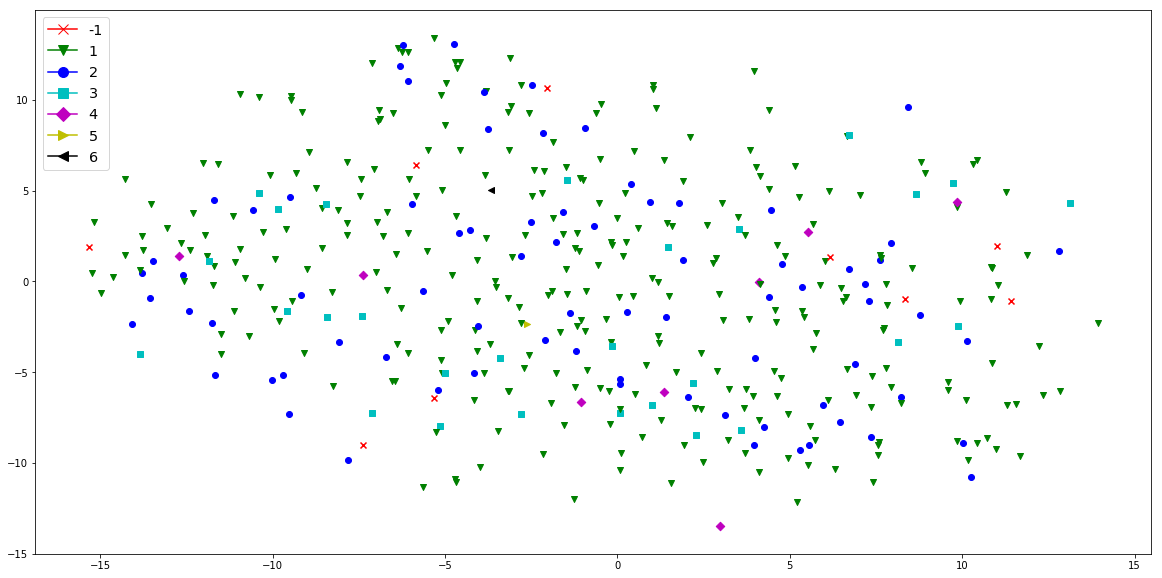

In [21]:
from matplotlib.lines import Line2D

fig, ax = plt.subplots(figsize=(20, 10))

markerDict = {0: "x", 1: "v", 2: "o", 3:"s", 4: "D" , 5: ">", 6: "<"}
colorDict = {0: "r", 1: "g", 2: "b", 3:"c", 4: "m" , 5: "y", 6: "k"}

victimDict = {-1 : 0, 1: 1, 2: 2, 3: 3, 4: 4, 5: 5, 6:6}

markers = []
colors = []

    
for inm in inmates:
    markers.append(markerDict[victimDict[inmates[inm]['NumVictims']]])
    colors.append(colorDict[victimDict[inmates[inm]['NumVictims']]])


for x,y,c,m in zip(t[0],t[1],colors,markers):
    ax.scatter(x, y, c=c, marker=m)
    

types = []

for race in victimDict:
    types.append(Line2D([0], [0], marker=markerDict[victimDict[race]], color=colorDict[victimDict[race]], label=race, markerfacecolor=colorDict[victimDict[race]], markersize=10))

ax.legend(handles=types, loc='upper left', fontsize='x-large')


plt.show()

# Plot by Length of Stay

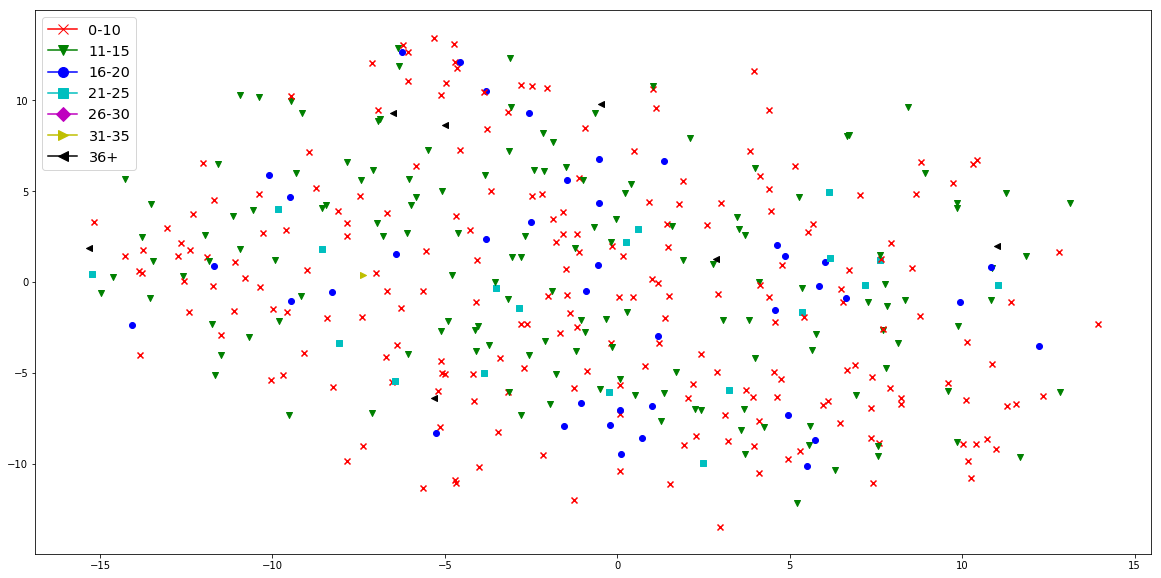

In [22]:
from matplotlib.lines import Line2D

fig, ax = plt.subplots(figsize=(20, 10))

markerDict = {0: "x", 1: "v", 2: "o", 3:"s", 4: "D" , 5: ">", 6: "<"}
colorDict = {0: "r", 1: "g", 2: "b", 3:"c", 4: "m" , 5: "y", 6: "k"}

stayDict = {'0-10': 0, '11-15':1,'16-20':2, '21-25':3,'26-30':4,'31-35':5,'36+':6}

def get_stay(age):
    if age <= 10:
        return '0-10'
    elif age <= 15:
        return '11-15'
    elif age <= 20:
        return '16-20'
    elif age <= 25:
        return '21-25'
    elif age <= 30:
        return '26-30'
    elif age <= 35:
        return '31-35'
    else:
        return '36+'


markers = []
colors = []

    
for inm in inmates:
    markers.append(markerDict[stayDict[get_stay(inmates[inm]['Age'] - inmates[inm]['AgeWhenReceived'])]])
    colors.append(colorDict[stayDict[get_stay(inmates[inm]['Age'] - inmates[inm]['AgeWhenReceived'])]])


for x,y,c,m in zip(t[0],t[1],colors,markers):
    ax.scatter(x, y, c=c, marker=m)
    

types = []

for race in stayDict:
    types.append(Line2D([0], [0], marker=markerDict[stayDict[race]], color=colorDict[stayDict[race]], label=race, markerfacecolor=colorDict[stayDict[race]], markersize=10))

ax.legend(handles=types, loc='upper left', fontsize='x-large')


plt.show()

In [ ]:
import pickle
inmDict = "inmatesDataAndEmbeddingsDict.pickle"
with open(inmDict, 'wb') as handle:
    pickle.dump(inmates, handle, protocol=pickle.HIGHEST_PROTOCOL)